In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# dataset and transformation
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from glob import glob
import os
from tqdm import tqdm
import pickle

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using mps for inference


In [2]:
# train test split

import csv
import shutil
import pandas as pd

train_list = []
test_list = []

train_csv=pd.read_csv('train.csv',index_col=0)
train_list=train_csv['video_id'].values.tolist()

test_csv=pd.read_csv('test.csv',index_col=0)
test_list=test_csv['video_id'].values.tolist()
#full_data_path = './data/'



print(f'csv len: {len(test_list) + len(train_list)}')
print("train len: ", len(train_list), "\ntest len: ", len(test_list))
# print(f'full data len: {len(os.listdir("./data"))}')

# for test in tqdm(test_list):
#   if os.path.exists('./medium_15287/' + test + '.jpg'):  
#     img_path = glob('./medium_15287/' + test + '.jpg')[0]
#     shutil.copyfile(img_path, './test/' + test + '.jpg')
  
#   else:
#     print(test)

# for train in tqdm(train_list):
#   if os.path.exists('./medium_15287/' + train + '.jpg'):  
#     img_path = glob('./medium_15287/' + train + '.jpg')[0]
#     shutil.copyfile(img_path, './train/' + train + '.jpg')
#   else:
#     print(train)




csv len: 15287
train len:  13758 
test len:  1529


In [3]:
print(f'test len: {len(os.listdir("./test"))}')
print(f'train len: {len(os.listdir("./train"))}')

test len: 1529
train len: 13758


In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class SampleDataset(Dataset):
    def __init__(self, phase='test'):
        # self.path = './sample_data'
        self.phase = phase
        
        self.img_list = glob(self.phase + '/*')

        self.transform = transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize((180,320), antialias=True),
                               transforms.Pad(padding=(0, 140), padding_mode='reflect'),
                               transforms.Resize((224, 224), antialias=True)
                         ])
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]

        img = Image.open(img_path)
        img = self.transform(img)

        vid = img_path.split('/')[-1][:-4]
        
        return img, vid

In [5]:
# Prepare sample input data.

batch_size = 64

test_dataset = SampleDataset(phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataset = SampleDataset(phase='train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [6]:
#train encoder
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
in_features=efficientnet._fc.in_features
print(efficientnet._fc)
efficientnet._fc=nn.Sequential(
    nn.Linear(in_features,100,bias=True) 
)
print(efficientnet._fc)
layer=0
for child in efficientnet.children():
    if layer<7:
        for param in child.parameters():
            param.requires_grad=False
    layer+=1

Loaded pretrained weights for efficientnet-b0
Linear(in_features=1280, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=1280, out_features=100, bias=True)
)


In [7]:
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = efficientnet
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(100, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 224*224*3),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
  
# Instantiating the model and hyperparameters


In [8]:
params_to_update=[]
for name, param in efficientnet.named_parameters():
    if param.requires_grad==True:
        params_to_update.append(param)

In [10]:
model = DeepAutoencoder()
model.to(device)
criterion = torch.nn.MSELoss()
num_epochs = 50

for name, param in model.decoder.named_parameters():
    if param.requires_grad==True:
        params_to_update.append(param)



In [63]:
optimizer = torch.optim.Adam(params_to_update, lr=1e-3)

In [64]:
num_epochs=200

In [65]:
for epoch in range(num_epochs):    
    model.train()
    with tqdm(train_dataloader, unit="batch") as batch:
        for img, vid in batch:
            batch.set_description(f"Epoch {epoch+1}")
            img=img.to(device)
            preds=model(img).flatten()
            img_f=img.flatten()
            batch_loss=criterion(preds.to(torch.float32),img_f.to(torch.float32))
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            batch.set_postfix(loss=batch_loss.item())
        
        

Epoch 200: 100%|██████████| 215/215 [01:26<00:00,  2.50batch/s, loss=0.0481]


torch.Size([3, 224, 224])
ehVbo3QEGd0


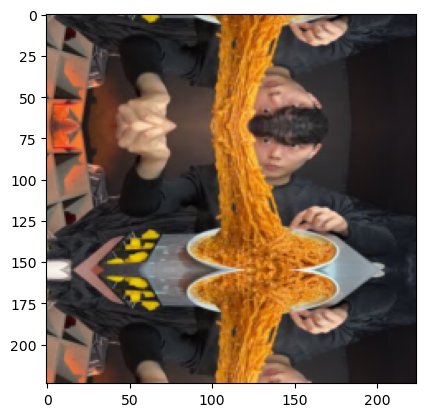

In [66]:
sample=iter(train_dataloader)
img, vid=next(sample)
print(img[6].shape)
print(vid[6])

plt.imshow(img[6].permute(1,2,0))

In [67]:
print(img.shape)

torch.Size([64, 3, 224, 224])


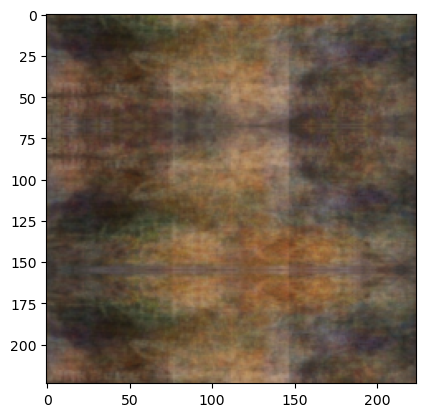

In [68]:
with torch.no_grad():
    img=img.to(device)
    decoded=model(img)
    
    decoded=decoded.reshape(64,3,224,224).cpu()
    
    plt.imshow(decoded[6].permute(1,2,0))

In [69]:
torch.save(model, 'autoencoder.pickle')

In [ ]:
save_data = {}

with torch.no_grad():
  for img, vid in tqdm(train_dataloader):
    out = model.encoder(img)
    for b in range(batch_size):
      if b < len(vid):
        save_data[vid[b]] = out[b]

print(f'train len: {len(train_list)}')
print(f'data len: {len(save_data)}')

with open('train.pickle', 'wb') as f:
  pickle.dump(save_data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:

with torch.no_grad():
  for img, vid in tqdm(test_dataloader):
    out = model.encoder(img)
    # print(features.shape)
    print(out, out.shape)
    for b in range(batch_size):
      if b < len(vid):
        save_data[vid[b]] = out[b]

print(f'test len: {len(train_list)}')
print(f'data len: {len(save_data)}')

with open('test.pickle', 'wb') as f:
  pickle.dump(save_data, f, pickle.HIGHEST_PROTOCOL)

데이터 로더 안쓰는 버전

In [ ]:
# # without dataloader ver

# from PIL import Image
# import pickle

# save_data = {}

# transform = transform=transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Pad(padding=(0, 140), padding_mode='reflect'),
#                                transforms.Resize((224, 224))
#                       ])

# for vid in tqdm(test_list):
#   img_path = './test/' + vid + '.jpg'

#   img = Image.open(img_path)
#   img = transform(img).unsqueeze(0)

#   # print(img.shape)

#   features = efficientnet.extract_features(img)
#   # print(features.shape)

#   save_data[vid] = features

# with open('test.pickle', 'wb') as f:
#   pickle.dump(save_data, f, pickle.HIGHEST_PROTOCOL)